# BERT Narration Classification

### Final Project - Vincent Gu
### DATASCI 266 - Section 3 - Summer 2023

## Background

As a model framework, BERT's pre-training on existing 'real' data such as Wikipedia provides an enormous repository
of context and position based word embeddings suitable as a starting point for a myriad of language tasks. Tuning this 
pre-trained model can lead to increased task accuracy for specific tasks and datasets.

However, how does BERT perform when presented with fictional text that differs substantially from the non-fiction
(Wikipedia) data it was trained on? Furthermore, how well can BERT be fine-tuned with fictional text to increase 
performance at a classification text? Finally, how well can BERT pick up subtle variations in word meanings based on 
surrounding fictional context?

To begin answering these questions, I leveraged the base BERT model with the science fiction novel 'Dark Age' by 
Pierce Brown. In the novel Brown crafts a dystopia in which mankind genetically engineered itsself into twelve distinct castes (colors in the book). Each color holds a certain function in society and inter-color marriage is forbidden and engineered to be biologically impossible. For example, Gold as the ruling class are engineered to be taller, stronger and smarter than Reds who toil as menial slave laborers.

The novel contains narration from 5 different individuals of different colors and perspectives and the corresponding language task involves classifying an excerpt of the text based on which narrator the model believes the text came 
from. I then looked to improve model performance by fine-tuning. Finally, I analyzed various out-of-context words 
specific to the world Pierce Brown created to determine if the fine-tuned BERT could pick up nuanced word meanings,
as represented in word embeddings, based on narrator.

The five narrators (classification buckets) are:
1. Darrow: A Red genetically 'carved' into a Gold warlord who led an uprising
2. Virginia: The Gold Sovereign (ruler) of a more egalitarian/reformed society
3. Ephraim: A Gray (foot soldier)
4. Lyria: A Red disillusioned with Virginia's society
5. Lysander: The last grandchild of the former Sovereign, a fascist slaver

## Objectives

- Build and train a fine-tuned BERT model to classify excerpts from the novel based on its narrator
- Determine if the model can pick up nuanced out-of-context word meanings based on the perspectives of each narrator

## Project Directory

* data (directory)
  * dark-age-raw-text.txt
* helpermodule (directory)
  * data.py
* models (directory - not in Github due to model size)
* **main.ipynb**
* BERT_base.py
* train_BERT_base.sh

## Data Setup

In [14]:
import sys
sys.path.append('helpermodule')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from helpermodule import data
from data import get_chapter_data, get_excerpt_data, format_data
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

The custom helpermodule package processes the raw text into labeled data. We have 2,822 excerpts of 100 words. Here is an example of the label associated with a given excerpt. 

In [2]:
excerpt_labels, excerpt_examples = get_excerpt_data(n_words=100)
print("# Excerpts:", len(excerpt_labels))
print(excerpt_labels[2550])
print(excerpt_examples[2550])

# Excerpts: 2822
Darrow
razor on the rooftops. Find it.” By the time the skinniest of them returns with my slingBlade in his trembling hands, another crowd has formed down the street. They’re trying to decide whether it’s worth rushing me. I take the blade from the boy. They see its shape. They run. I nod to the Red and, weighed down by forty kilos of dead armor, rush to ﬁnd my men. My miracle has turned into bedlam. Heliopolis is in chaos. Screams drift over the city. The streets are pitch dark. Gunshots crackle from conventional arms. Downed ships smolder and send black


Here we generate train/test sets.

In [3]:
x_train, x_test, y_train, y_test = train_test_split(excerpt_examples, excerpt_labels, test_size=.2, random_state=2457)
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

2257
565
2257
565


# BERT Setup

In [4]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from keras.utils import to_categorical
import seaborn as sns

import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertModel
from transformers import logging
tf.get_logger().setLevel('ERROR')

In [5]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


## Training the Fine-Tuned Models

To gauge various model training behaviors, the fine-tuned BERT model was trained using a number of batch sizes: **8, 18, 32, 64** and two excerpt sizes" **100, 256**. In this setting, a single labeled observation (data point) would be comprised of either 100 or 256 words. Training details are saved as screenshots under the **training_screenshots** folder.

As BERT's underlying transformer architecture requires significant computational resources, models were trained using GPU as opposed to CPU. Attempting to train on CPU look approximately two hours per epoch which was cut to between 5-15 minutes per epoch with GPU.

Due to the size of these models, they were trained via commandline with the shell script **train_BERT.sh** which makes sucessive calls to **BERT_base.py**. These individual .py calls are parameterized with both the batch size and excerpt size. 

Overall, the models were able to learn a significant amount during training with final epoch validation accuracies around 80%. We see in initial epochs many models start off with about 20% validation accuracy - which indicates that at this point the model isn't performing any better at sorting into the five bins than it would if it was just randomly guessing. However, the substantial increases in validation accuracy over epochs demonstrates BERT's ability to learn.

*Best Performing Model*

In [6]:
model_bert = tf.keras.models.load_model('./models/bert_classification_model_16_256.h5', custom_objects={"TFBertModel": bert_model})
x_train, x_test, y_train, y_test = format_data(n=100)
#x_train, x_test, y_train, y_test = train_test_split(excerpt_examples, excerpt_labels, test_size=.2, random_state=2457)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [20]:
model_bert.evaluate([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask],
                                    y_test)

18/18 [==============================] - 28s 2s/step - loss: 1.5981 - accuracy: 0.2885


18/18 [==============================] - 30s 2s/step


<Axes: >

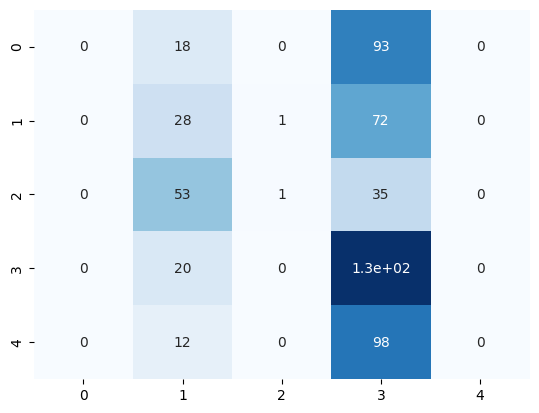

In [8]:
bert_cm = tf.math.confusion_matrix(
    np.argmax(y_test, axis=1),
    np.argmax(model_bert.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask]), axis=1),
)
sns.heatmap(bert_cm, annot=True, cbar=False, cmap="Blues")

## Analysis of Out-of-Context Words

In [60]:
encoded_text = bert_tokenizer("Gold", return_tensors='tf')

#Vector representation for "Gold" in pre-trained model
emb_1 = bert_model(encoded_text)[0][0, 1]
emb_1

<tf.Tensor: shape=(768,), dtype=float32, numpy=
array([ 2.11537808e-01, -5.85049033e-01,  2.49567509e-01, -3.47646475e-01,
       -8.18176746e-01,  1.97755694e-01,  3.98829728e-01, -4.51668620e-01,
        2.48744711e-01, -1.16943574e+00, -5.71029708e-02,  7.60794878e-01,
       -1.02610558e-01, -6.28937632e-02, -9.31132734e-01,  5.55867791e-01,
        6.91198632e-02,  6.39091313e-01, -3.07213627e-02, -3.95802945e-01,
       -9.21144336e-02, -2.59645909e-01,  6.40626073e-01, -5.45688272e-01,
       -2.98271924e-01,  3.82909365e-02,  6.12525702e-01,  3.85674179e-01,
       -9.34098721e-01,  4.77753580e-01,  6.95850551e-02, -4.89636399e-02,
       -1.92698240e-01,  1.95427015e-01, -2.95660704e-01, -3.06239843e-01,
        1.77758276e-01,  5.30959666e-02,  1.86508268e-01, -5.16496226e-02,
       -6.61048830e-01, -2.38469169e-02,  8.13131273e-01,  1.51765972e-01,
       -3.38114321e-01, -4.51608956e-01,  2.31282655e-02,  3.58673573e-01,
       -4.93296266e-01, -2.07823645e-02, -3.23579222

In [62]:
#Vector representation for "Gold" in pre-trained model
emb_2 = print(model_bert.layers[3](encoded_text)[0][0, 1])
emb_2

tf.Tensor(
[-1.58516526e-01 -3.68443936e-01  7.32981384e-01  1.99113432e-02
 -1.56415746e-01 -8.11172426e-02  3.43863010e-01  5.54069653e-02
 -1.31554514e-01 -1.22576065e-01  8.52630138e-02  4.29312676e-01
 -1.17089242e-01  1.54653296e-01 -2.48663858e-01  7.53319681e-01
  2.24459738e-01  2.06734493e-01 -2.52275020e-01 -2.34125495e-01
 -2.00704411e-02  2.08626613e-01 -4.21744257e-01 -1.92100689e-01
 -3.75723802e-02 -4.27761108e-01  4.61040646e-01  2.98211753e-01
 -1.17127076e-01  6.92551970e-01  1.20481670e-01  3.84461284e-01
 -2.79962391e-01 -1.16014473e-01  7.86475837e-02 -1.11985184e-01
 -3.34366441e-01  3.34439546e-01 -1.67179212e-01 -2.01846942e-01
  1.30690202e-01 -2.11219311e-01  1.59090936e-01  4.15440500e-01
  4.53365326e-01 -2.71402478e-01  3.75166714e-01  3.79360430e-02
 -7.05640495e-01 -3.30345631e-02 -1.05052784e-01 -1.84894428e-01
  7.15169907e-02  1.49576858e-01 -1.14154644e-01 -2.65385687e-01
  6.11505751e-03 -4.66674566e-01 -2.89244562e-01  2.10789591e-01
  1.71164811e-